# Face Recognition with LBP(cv2.face.LBPHFaceRecognizer_create())

This notebook is an example for face recognition with LBP(local binary pattern). The original codes and images are avalaible in the reference links. Explanation of Local Binary Pattern is not this notebook's subjects. Special thanks to https://pyimagesearch.com/ for clear explanation about this concept. You can check website for details and examples for other concepts.


We will see how to use 'cv2.face.LBPHFaceRecognizer_create()' for face recognition by LBP.

In [5]:
#first import necessary packages

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import imutils
from imutils import paths
import time
import cv2
import os

print('PACKAGES ARE LOADED...')

PACKAGES ARE LOADED...




We should prepare our dataset for training model. From the dataset folder, we will take each image and its name, extract faces from images and apply LBP to these faces. For this reason we should write a face detection algorithm. You can use another face detector model (yolo,haarcascade,mediapipe etc.) , just be careful about your model returns a roi with face.



In [3]:
#prepare net for face detection
prototxtPath = "deploy.prototxt"
weightsPath = "res10_300x300_ssd_iter_140000.caffemodel"
net = cv2.dnn.readNet(prototxtPath, weightsPath)

In [11]:
inputPath='caltech_faces'
imagePaths = list(paths.list_images(inputPath))
print(imagePaths)

['caltech_faces\\abraham\\image_0022.jpg', 'caltech_faces\\abraham\\image_0023.jpg', 'caltech_faces\\abraham\\image_0024.jpg', 'caltech_faces\\abraham\\image_0025.jpg', 'caltech_faces\\abraham\\image_0026.jpg', 'caltech_faces\\abraham\\image_0027.jpg', 'caltech_faces\\abraham\\image_0028.jpg', 'caltech_faces\\abraham\\image_0029.jpg', 'caltech_faces\\abraham\\image_0030.jpg', 'caltech_faces\\abraham\\image_0031.jpg', 'caltech_faces\\abraham\\image_0032.jpg', 'caltech_faces\\abraham\\image_0033.jpg', 'caltech_faces\\abraham\\image_0034.jpg', 'caltech_faces\\abraham\\image_0035.jpg', 'caltech_faces\\abraham\\image_0036.jpg', 'caltech_faces\\abraham\\image_0037.jpg', 'caltech_faces\\abraham\\image_0038.jpg', 'caltech_faces\\abraham\\image_0039.jpg', 'caltech_faces\\abraham\\image_0040.jpg', 'caltech_faces\\abraham\\image_0041.jpg', 'caltech_faces\\alberta\\image_0166.jpg', 'caltech_faces\\alberta\\image_0167.jpg', 'caltech_faces\\alberta\\image_0168.jpg', 'caltech_faces\\alberta\\image_01

In [12]:
names = [p.split(os.path.sep)[-2] for p in imagePaths]
print(names)

['abraham', 'abraham', 'abraham', 'abraham', 'abraham', 'abraham', 'abraham', 'abraham', 'abraham', 'abraham', 'abraham', 'abraham', 'abraham', 'abraham', 'abraham', 'abraham', 'abraham', 'abraham', 'abraham', 'abraham', 'alberta', 'alberta', 'alberta', 'alberta', 'alberta', 'allen', 'allen', 'allen', 'allen', 'allen', 'allen', 'allen', 'allen', 'allen', 'allen', 'allen', 'allen', 'allen', 'allen', 'allen', 'allen', 'allen', 'allen', 'allen', 'allen', 'allen', 'allen', 'allen', 'allen', 'allen', 'allen', 'allen', 'allen', 'allen', 'carmen', 'carmen', 'carmen', 'carmen', 'carmen', 'carmen', 'carmen', 'carmen', 'carmen', 'carmen', 'carmen', 'carmen', 'carmen', 'carmen', 'carmen', 'carmen', 'carmen', 'carmen', 'carmen', 'carmen', 'conrad', 'conrad', 'conrad', 'conrad', 'conrad', 'conrad', 'conrad', 'conrad', 'conrad', 'conrad', 'conrad', 'conrad', 'conrad', 'conrad', 'conrad', 'conrad', 'conrad', 'conrad', 'conrad', 'conrad', 'conrad', 'conrad', 'conrad', 'cynthia', 'cynthia', 'cynthia', 

I used 'print' command to show 'what these codes return'. As you can see, we take the names from folder names. Because of that reason, you should be careful about your dataset folders' names. 

In [13]:

(names, counts) = np.unique(names, return_counts=True)
print(counts)
print(names)


[20  5 29 20 23 20 21 19 21  5 20 22 21 20  5 21  5 21  5 22 22  5 21 20
 25  7]
['abraham' 'alberta' 'allen' 'carmen' 'conrad' 'cynthia' 'darrell' 'flyod'
 'frank' 'glen' 'gloria' 'jacques' 'judy' 'julie' 'kathleen' 'kenneth'
 'lewis' 'mae' 'phil' 'raymond' 'rick' 'ronald' 'sherry' 'tiffany'
 'willie' 'winston']


In [14]:
names = names.tolist()
print(names)

['abraham', 'alberta', 'allen', 'carmen', 'conrad', 'cynthia', 'darrell', 'flyod', 'frank', 'glen', 'gloria', 'jacques', 'judy', 'julie', 'kathleen', 'kenneth', 'lewis', 'mae', 'phil', 'raymond', 'rick', 'ronald', 'sherry', 'tiffany', 'willie', 'winston']


In [15]:
#initialize two list to save faces and labels(name of person)
faces = []
labels = []

In [16]:
for imagePath in imagePaths:
        # load the image from disk and extract the name of the person
        # from the subdirectory structure
    image = cv2.imread(imagePath)
    name = imagePath.split(os.path.sep)[-2]

        # only process images that have a sufficient number of
        # examples belonging to the class
    if counts[names.index(name)] < 6:
        continue

        # perform face detection
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),(104.0, 177.0, 123.0))

    # pass the blob through the network to obtain the face detections,
    # then initialize a list to store the predicted bounding boxes
    net.setInput(blob)
    detections = net.forward()
    boxes = []

    # loop over the detections
    for i in range(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with
        # the detection
        confidence = detections[0, 0, i, 2]

        # filter out weak detections by ensuring the confidence is
        # greater than the minimum confidence
        if confidence > 0.7:
            # compute the (x, y)-coordinates of the bounding box for
            # the object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            # update our bounding box results list
            boxes.append((startX, startY, endX, endY))
    

        # loop over the faces
    for (startX, startY, endX, endY) in boxes:
        # extract the face ROI, resize it, and convert it to
        # grayscale
        faceROI = image[startY:endY, startX:endX]
        faceROI = cv2.resize(faceROI, (47, 62))
        faceROI = cv2.cvtColor(faceROI, cv2.COLOR_BGR2GRAY)

        # update our faces and labels lists
        faces.append(faceROI)
        labels.append(name)

In [17]:
faces = np.array(faces)
labels = np.array(labels)


In [20]:
print(np.shape(faces))
print(np.shape(labels))

(416, 62, 47)
(416,)


We have 416 faces with 47x62 dimensions and 416 labels.

In [21]:
print(len(imagePaths))

445


As you can see,in our dataaset folder we have 445 images but we extract 416 faces. The difference can be from face detection part or the filter for sufficient number of examples(which we set 6).

Now we have faces and labels... Let's train model with these data.


In [22]:
# encode the string labels as integers
le = LabelEncoder()
labels = le.fit_transform(labels)
print(labels)

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15

In [23]:
 # training and testing split
(trainX, testX, trainY, testY) = train_test_split(faces,labels, test_size=0.25, stratify=labels, random_state=42)

Now we come to the most important part of this notebook, initialize the LBPHFaceRecognizer_create(). For a good parameter selection, we must know what they mean. I won't explain the LBP concept deeply, but I should mention parameters roughly.

When you check the doc of OpenCV  for cv.face.LBPHFaceRecognizer_create(), you will see this page and it is a good brief about parameters : 

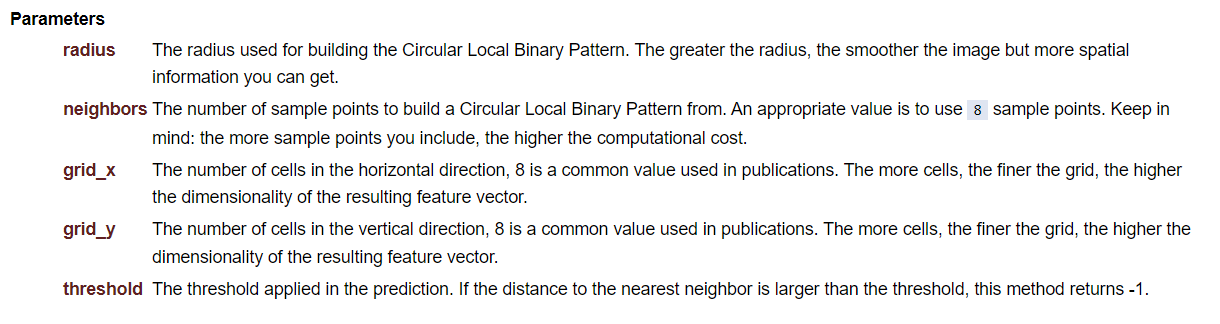


For radius and neighbors parameter, I want to use a screenshot from https://pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/ :

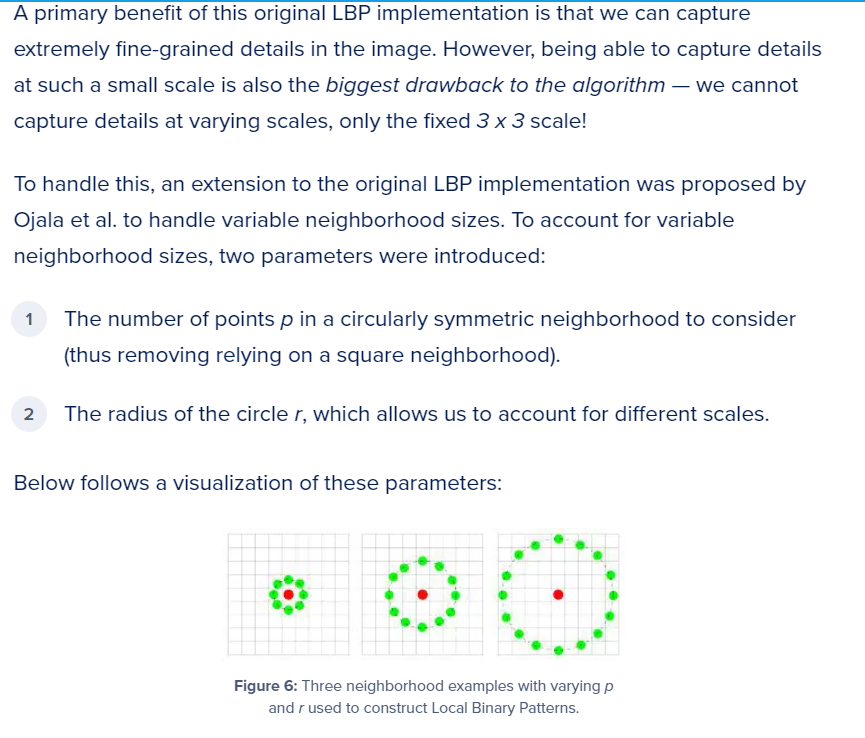


To apply LBP for face recognition, the image of face should be divided into MxN cells. The grid parameters are using for these numbers. Again an image from same link can be a good example:

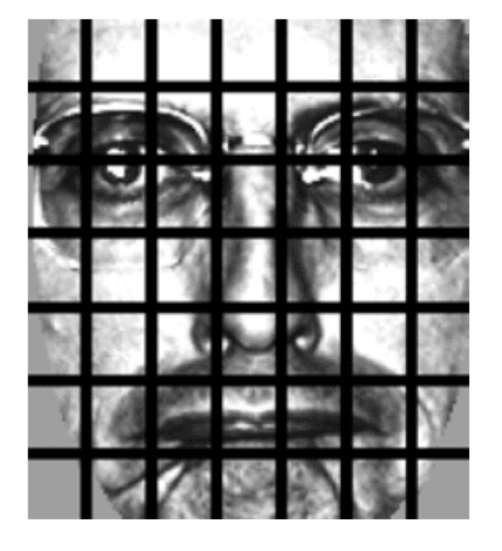



In [24]:
recognizer = cv2.face.LBPHFaceRecognizer_create(radius=2, neighbors=16, grid_x=8, grid_y=8)
start = time.time()
recognizer.train(trainX, trainY)
end = time.time()
print("training took {:.4f} seconds".format(end - start))

training took 1.4746 seconds


We trained our model on cpu in 1.48 sec. We will test our model results on test data.

In [25]:
predictions = []
confidence = []
start = time.time()

# loop over the test data
for i in range(0, len(testX)):
    # classify the face and update the list of predictions and
    # confidence scores
    (prediction, conf) = recognizer.predict(testX[i])
    predictions.append(prediction)
    confidence.append(conf)

# measure how long making predictions took
end = time.time()
print("inference took {:.4f} seconds".format(end - start))

inference took 157.5884 seconds


In [26]:
# show the classification report
print(classification_report(testY, predictions,target_names=le.classes_))

              precision    recall  f1-score   support

     abraham       1.00      1.00      1.00         5
       allen       1.00      1.00      1.00         7
      carmen       1.00      1.00      1.00         5
      conrad       1.00      1.00      1.00         6
     cynthia       1.00      0.80      0.89         5
     darrell       1.00      1.00      1.00         5
       flyod       0.71      1.00      0.83         5
       frank       1.00      1.00      1.00         5
      gloria       1.00      1.00      1.00         5
     jacques       1.00      0.83      0.91         6
        judy       1.00      1.00      1.00         5
       julie       1.00      1.00      1.00         5
     kenneth       0.83      1.00      0.91         5
         mae       1.00      1.00      1.00         5
     raymond       1.00      1.00      1.00         6
        rick       1.00      1.00      1.00         5
      sherry       1.00      0.83      0.91         6
     tiffany       1.00    

Inference took 157 sec and the classification report show 'how successful our model'. If you have any question about the training, test and classification report part, you should check some machine learning basics to understand.

Adrian Rosebrock also prepared a nice code block to show these result on images.

In [27]:
idxs = np.random.choice(range(0, len(testY)), size=10, replace=False)
print(idxs)

[31 26 12 11 59 74 75  6 85  4]


we will take 10 images randomly from our test set and show the result for each one.

In [28]:
for i in idxs:
    # grab the predicted name and actual name
    predName = le.inverse_transform([predictions[i]])[0]
    actualName = le.classes_[testY[i]]

    # grab the face image and resize it such that we can easily see
    # it on our screen
    face = np.dstack([testX[i]] * 3)
    face = imutils.resize(face, width=250)

    # draw the predicted name and actual name on the image
    cv2.putText(face, "pred: {}".format(predName), (5, 25),cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
    cv2.putText(face, "actual: {}".format(actualName), (5, 60),cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

    # display the predicted name, actual name, and confidence of the
    # prediction (i.e., chi-squared distance; the *lower* the distance
    # is the *more confident* the prediction is)
    print("[INFO] prediction: {}, actual: {}, confidence: {:.2f}".format(
        predName, actualName, confidence[i]))

    # display the current face to our screen
    cv2.imshow("Face", face)
    cv2.waitKey(0)

[INFO] prediction: carmen, actual: carmen, confidence: 195.50
[INFO] prediction: rick, actual: rick, confidence: 160.70
[INFO] prediction: flyod, actual: flyod, confidence: 156.23
[INFO] prediction: gloria, actual: gloria, confidence: 114.32
[INFO] prediction: mae, actual: mae, confidence: 140.17
[INFO] prediction: abraham, actual: abraham, confidence: 168.64
[INFO] prediction: sherry, actual: sherry, confidence: 161.52
[INFO] prediction: flyod, actual: jacques, confidence: 203.45
[INFO] prediction: kenneth, actual: kenneth, confidence: 169.86
[INFO] prediction: carmen, actual: carmen, confidence: 195.20


In this notebook, I mentioned about cv2.face.LBPHFaceRecognizer_create to use LBP for face recognition. I tried to explain each layer as much as I can. You can check the reference links for more information.


REFERENCE LINKS : 
* https://pyimagesearch.com/2021/05/03/face-recognition-with-local-binary-patterns-lbps-and-opencv/

* https://docs.opencv.org/3.4/df/d25/classcv_1_1face_1_1LBPHFaceRecognizer.html#ac33ba992b16f29f2824761cea5cd5fc5

* https://pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/
